In [1]:
import pandas as pd
import numpy as np
import warnings
import pandas_profiling
import missingno as msno
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder,Normalizer,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression, Ridge, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix 
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

In [2]:
data=pd.read_csv('preprocessed_data.csv')

In [3]:
data=data.rename(columns={' ID':'ID',' AdmissionDate':'AdmissionDate',' DischargeDate':'DischargeDate',' CCOutcome':'CCOutcome',
                         ' HospOutcome':'HospOutcome',' VentMode':'VentMode',' PS_Above_PEEP':'PS_Above_PEEP',
                          ' EPAP_PEEP':'EPAP_PEEP',' SET_FIO2':'SET_FIO2',' Spont_RR':'Spont_RR',' Deadspace':'Deadspace',' SBI':'SBI',' P01':'P01',
                         ' HeartRate':'HeartRate',' ArtSystollic':'ArtSystollic',' ArtMAP':'ArtMAP',' PH':'PH',' PaO2':'PaO2',
                         ' PaCO2':'PaCO2',' LactateABG':'LactateABG',' HeartRate':'HeartRate',' ArtSystollic':'ArtSystollic',
                         ' ArtMAP':'ArtMAP',' Temperature':'Temperature'})

In [4]:
dataNaN=data.replace(' NULL',np.nan)

In [5]:
a=pd.to_datetime(dataNaN.DischargeDate)-pd.to_datetime(dataNaN.AdmissionDate)
a=a.abs()
dataNaN['TIMEDELTA']=np.round(a.dt.total_seconds()/86400, 2)

In [6]:
dataNaN=dataNaN.drop(['Time','Unnamed: 0','HospOutcome','AdmissionDate','DischargeDate'],axis=1)

In [7]:
BYTES_TO_MB_DIV=0.000001
def print_memory_usage_of_data_frame(df):
    mem=round(df.memory_usage().sum()*BYTES_TO_MB_DIV,3)
    print('Memory usage is '+str(mem)+'MB')
print_memory_usage_of_data_frame(dataNaN)

Memory usage is 571.704MB


In [8]:
for col in ['PS_Above_PEEP','EPAP_PEEP', 'SET_FIO2', 'Spont_RR', 'Deadspace', 'SBI', 'P01', 'PH',
            'PaCO2', 'PaO2', 'LactateABG', 'HeartRate', 'ArtSystollic', 'ArtMAP','Temperature']:
    dataNaN[col] = dataNaN[col].astype('float64')

In [9]:
cols=['PS_Above_PEEP', 'Spont_RR', 'Deadspace', 'SBI', 'P01', 'PH',
            'PaCO2', 'PaO2', 'LactateABG', 'ArtSystollic', 'ArtMAP','Temperature']
for c in cols:
    dataNaN[c]=dataNaN[c].replace(np.nan,dataNaN[c].mean())

In [10]:
dataNaN=dataNaN.replace(np.nan,0)

#### Splitting the Data into train and test data sets

In [11]:
train,test=train_test_split(dataNaN,test_size=0.3,random_state=42)

#### Scatter plots
The Scatter plot is a technique that can be used to investigate the relationships between variables. It includes plots of each vector in the dataset against each other. If the function vector has a large number of variables, including all scatter plots can be difficult to visualise. Examine the scatter plot for the target variable and other attributes.

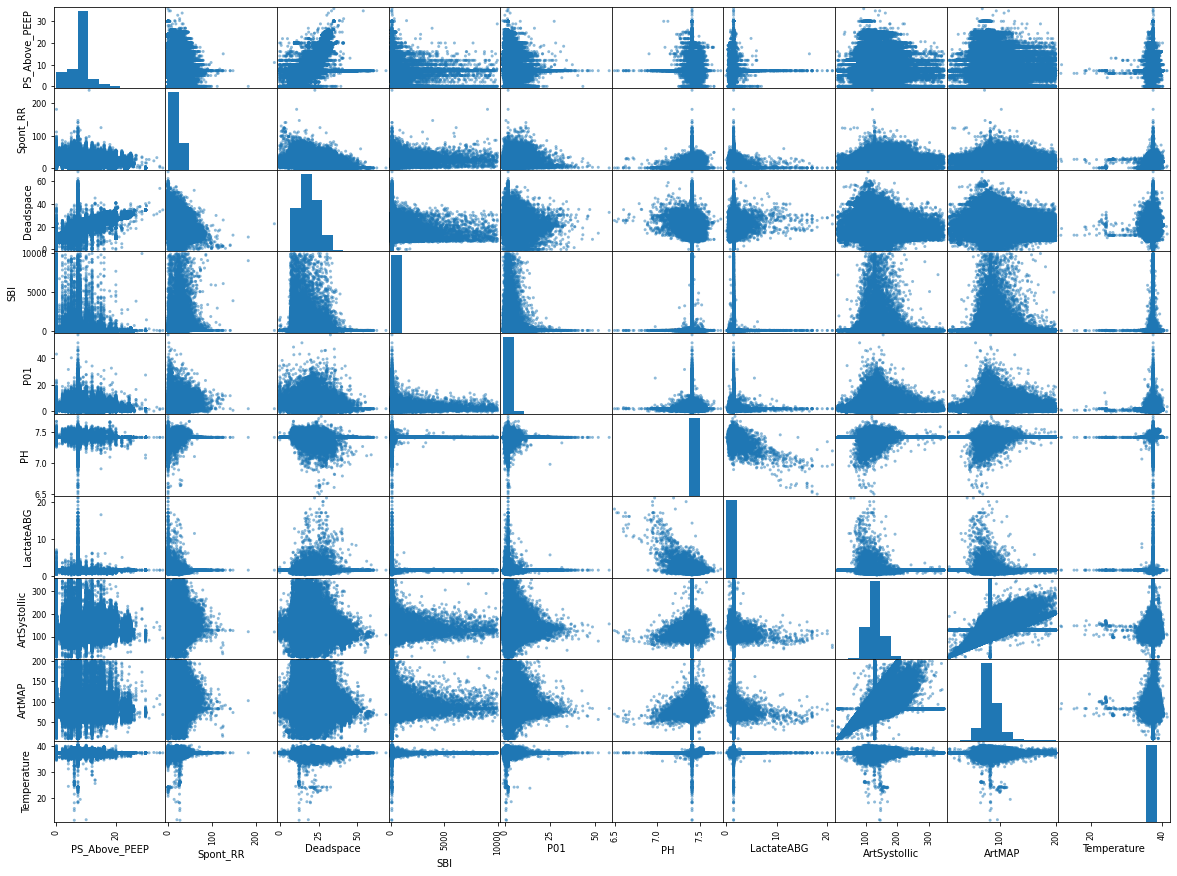

In [12]:
from pandas.plotting import scatter_matrix
attributes = ['PS_Above_PEEP', 'Spont_RR', 'Deadspace', 'SBI', 'P01', 'PH','LactateABG', 'ArtSystollic', 'ArtMAP','Temperature']
figscat = scatter_matrix(train[attributes], figsize=(20, 15))

#### Prepare the data
We'll now plan the data so that it can be used by machine learning algorithms. In this notebook, we consider the following processes for the dataset: For categorical attributes, one-hot encoding is used, and function scaling is used for numerical attributes. Scikit-learn has utilities to help with these tasks:

1. OneHotEncoder() allows to transform a categorical variable to a one-hot encoding representation.

2. StandardScaler() performs feature scaling by standardisation.

3. Normalizer() Normalization, also known as scaling, is used to ensure that all functions fall between a given minimum and maximum value, which is usually between zero and one. During the training process, the maximum and minimum values of each element should be calculated, and the same values should be used during the testing phase.

Data transformations include OneHotEncoder() and StandardScaler(). These are known as transformers in scikit-learn, and they map data from one format to another. Transformers are classes in a programming context. They are available in the following methods:

- fit that is used to learn the transformation from data.
- transform that is used to transform the data once the transformer has been fitted.
- fit_transform that applies first fit and then transform to the data.

Typically, we use either a fit or fit_transform for the training data and transform to the validation or test data.

Since the one-hot-encoding and standardisation transformations may be extended to separate columns in the dataset, having a function that applies both is useful. It is especially useful since such transformations must be applied to the train, validation, and test sets.We might write such a function from scratch, but in this case, we use ColumnTransformer(), a scikit-learn estimator that helps us to combine several transformations into a single process. ColumnTransformer is an example of a scikit-learn estimator.An estimator is a type of object that predicts new data. In addition to the match, transform, and fit transform methods, they often provide a predict method for making projections on test results.

In [13]:
attributes_cat=['CCOutcome','VentMode']
attributes_num=['EPAP_PEEP', 'SET_FIO2','HeartRate']
full_transform=ColumnTransformer([
    ('cat',OneHotEncoder(),attributes_cat),
    ('num',StandardScaler(),attributes_num)
],remainder='passthrough')

In [14]:
train_att=dataNaN.drop('PS_Above_PEEP',axis=1)
train_label_reg=dataNaN['PS_Above_PEEP']

test_att=dataNaN.drop('PS_Above_PEEP',axis=1)
test_label_reg=dataNaN['PS_Above_PEEP']

In [15]:
train_att_trans_reg=full_transform.fit_transform(train_att)
test_att_trans_reg=full_transform.transform(test_att)

#### Model training

In [16]:
corr_mat=dataNaN.corr()
corr_mat['PS_Above_PEEP'].sort_values(ascending=False)

PS_Above_PEEP    1.000000
Deadspace        0.581442
EPAP_PEEP        0.149556
SET_FIO2         0.103925
HeartRate        0.020244
ArtSystollic     0.013120
ID               0.009777
PaCO2            0.006062
Temperature      0.003700
LactateABG      -0.000299
PaO2            -0.000418
TIMEDELTA       -0.000832
PH              -0.002367
Spont_RR        -0.014154
SBI             -0.026338
ArtMAP          -0.038444
P01             -0.107379
Name: PS_Above_PEEP, dtype: float64

### Linear Regression

In [17]:
lr=LinearRegression(n_jobs=None,normalize=True,fit_intercept=False)
lr.fit(train_att_trans_reg,train_label_reg)

predictions=lr.predict(test_att_trans_reg)

error_lr=np.sqrt(mean_squared_error(test_label_reg,predictions))
error_lr

2.5431635744336556

#### Grid search 

In [19]:
whole_train_set_attributes=np.vstack((train_att_trans_reg,test_att_trans_reg))
whole_train_set_labels=np.hstack((train_label_reg,test_label_reg))

In [20]:
param_grid = {'fit_intercept': [True,False],
              'normalize':[True,False],
              'n_jobs':[None,-1,1],
              'copy_X':[True,False]}
lr_grid = GridSearchCV(estimator=LinearRegression(), param_grid=param_grid,
                       cv=5,scoring='neg_mean_squared_error')
lr_grid.fit(whole_train_set_attributes,whole_train_set_labels)

GridSearchCV(cv=5, estimator=LinearRegression(),
             param_grid={'copy_X': [True, False],
                         'fit_intercept': [True, False],
                         'n_jobs': [None, -1, 1], 'normalize': [True, False]},
             scoring='neg_mean_squared_error')

In [21]:
lr_grid.best_params_

{'copy_X': True, 'fit_intercept': True, 'n_jobs': 1, 'normalize': True}

### Logistic Regression

When starting a machine learning project, it is usually a good idea to start with a really basic model because it will give you an idea of how difficult the question is. Logistic regression (LR) is regarded as a simplistic model since the underlying math is simple to grasp, making its parameters and outcomes understandable. It also takes longer to compute than other ML models.

In [22]:
dataNaN.CCOutcome[dataNaN.CCOutcome==' A']=1
dataNaN.CCOutcome[dataNaN.CCOutcome==' D']=0

In [23]:
dataNaN['CCOutcome']=dataNaN['CCOutcome'].astype('int64')

In [24]:
attributes_cat=['VentMode']
attributes_num=['EPAP_PEEP', 'SET_FIO2','HeartRate']
full_transform=ColumnTransformer([
    ('cat',OneHotEncoder(),attributes_cat),
    ('num',Normalizer(),attributes_num)
],remainder='passthrough')

In [25]:
train,test=train_test_split(dataNaN,test_size=0.3,random_state=42)

In [26]:
train_att=dataNaN.drop('CCOutcome',axis=1)
train_label=dataNaN['CCOutcome']

test_att=dataNaN.drop('CCOutcome',axis=1)
test_label=dataNaN['CCOutcome']

In [27]:
train_att_trans=full_transform.fit_transform(train_att)
test_att_trans=full_transform.transform(test_att)

In [28]:
log_reg=LogisticRegression(penalty='l1',solver='saga')
log_reg.fit(train_att_trans,train_label)

LogisticRegression(penalty='l1', solver='saga')

In [29]:
acc_score_test_set=log_reg.score(test_att_trans,test_label)
print(acc_score_test_set)

0.8062392670871164


#### Principal Component Analysis(PCA)

The first discussion of this technique was made in 1933 by Harold Hotelling in a paper on principal component analysis. Hotelling was inspired to establish a statistical basis for factor analysis approaches, which were commonly used in psychology and the social sciences at the time. His model was a factor analysis model, but he found the model's noiseless 'limit.'



In [30]:
pca=PCA(n_components=4)
pca.fit(train_att_trans)

PCA(n_components=4)

#### Explained Variance
- The explained variance tells us how much information can be attributed to each other of the principal components.
- This is important, cause we convert 15 dimension space to 4 dimension space, we may loose some of the information.

In [31]:
pca.explained_variance_ratio_

array([9.63657377e-01, 2.84822705e-02, 6.93368588e-03, 6.57754961e-04])

In [32]:
train_att_trans=pca.transform(train_att_trans)
test_att_trans=pca.transform(test_att_trans)

In [33]:
# Apply the logistic regression
lr=LogisticRegression()

lr.fit(train_att_trans,train_label)

LogisticRegression()

In [34]:
# predictions=lr.predict(test_att_trans)
acc_score_test_set=lr.score(test_att_trans,test_label)
print(acc_score_test_set)

0.8028350443514071


#### Clustering

Clustering is a learning task that attempts to divide a given collection of observations into subgroups (clusters) based on data similarities, so that observations in the same cluster are more closely related to one another than observations in different clusters.It is an unsupervised learning task because it detects structures in unlabeled datasets, and a classification task because it can classify findings based on the cluster to which they are assigned.


K-means clustering algorithm
Consider a (training) dataset composed of $N$ observations:

$$
\begin{aligned}
x_1, x_2,..., x_N
\end{aligned}
$$
Initialize K centroids $\mu_1, \mu_2, ..., \mu_K$ randomly.

Repeat until convergence:

Cluster assignment

Assign each $x_i$ to the nearest cluster.
For every $i$ do:
$$
\begin{aligned}
\underset{j}{argmin}\left \| x_i-\mu_j \right \|^2,
\end{aligned}
$$where $j=1,2,...,K$

Cluster updating

Update the cluster centroids $\mu_j$.
For every $j$ do:$$
\begin{aligned}
\mu_j = \frac{1}{N_j}\left [ x_1^j + x_2^j + ... + x_{N_j}^j \right ],
\end{aligned}
$$where $N_j$ is the number of observations assigned to cluster $j$, $k=1,2, ..., N_j$, and $x_k^j$ represents observation $k$ assigned to cluster $j$.

In [35]:
scaler=StandardScaler()
ohe=OneHotEncoder()
normalizer=Normalizer()
kmeans=KMeans(n_clusters=4)
lr=LinearRegression(n_jobs=None,normalize=True,fit_intercept=False)

#### Pipeline
A pipeline enables the combination of several estimators into a single one. It is useful in a machine learning project since the various stages (e.g., data preprocessing, function collection, prediction) can be placed sequentially one after the other in a single instruction.

Let us return to the dataset and implement the transformations we discussed earlier. We begin by creating lists of the names of the attributes, one for categorical attributes and one for numerical attributes.

In [36]:
pipeline=make_pipeline(scaler,normalizer,kmeans,lr)

In [37]:
pipeline.fit(train_att_trans,train_label)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('normalizer', Normalizer()), ('kmeans', KMeans(n_clusters=4)),
                ('linearregression',
                 LinearRegression(fit_intercept=False, normalize=True))])

In [38]:
predictions=pipeline.predict(test_att_trans)

In [39]:
from sklearn.metrics import mean_squared_error
error_lr=np.sqrt(mean_squared_error(test_label,predictions))
error_lr

0.39628068434122

In [40]:
dataNaN.CCOutcome[dataNaN.CCOutcome==' A']=1
dataNaN.CCOutcome[dataNaN.CCOutcome==' D']=0

In [41]:
dataNaN['CCOutcome']=dataNaN['CCOutcome'].astype('int64')
attributes_cat=['VentMode']
full_transform=ColumnTransformer([
    ('cat',OneHotEncoder(),attributes_cat),
],remainder='passthrough')

In [42]:
train,test=train_test_split(dataNaN,test_size=0.3,random_state=42)

In [43]:
train_att=dataNaN.drop('CCOutcome',axis=1)
train_label=dataNaN['CCOutcome']

test_att=dataNaN.drop('CCOutcome',axis=1)
test_label=dataNaN['CCOutcome']

In [44]:
train_att_trans=full_transform.fit_transform(train_att)
test_att_trans=full_transform.transform(test_att)

In [45]:
log_reg=LogisticRegression()

In [46]:
pipeline=make_pipeline(scaler,normalizer,kmeans,log_reg)

In [47]:
pipeline.fit(train_att_trans,train_label)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('normalizer', Normalizer()), ('kmeans', KMeans(n_clusters=4)),
                ('logisticregression', LogisticRegression())])

In [48]:
acc_score_training_set=pipeline.score(train_att_trans,train_label)
print(acc_score_training_set)

0.8028350443514071


In [49]:
pipeline.predict(test_att_trans)

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

#### Decision Tree classifier

Most ICU severity scores are constructed using logistic regression, which imposes stringent constraints on the relationship between explanatory variables and outcome. Logistic regression, in particular, is based on the concept of a linear and additive relationship between the result and its predictors. This prediction may be unrealistic given the complexity of the processes causing death in ICU patients.

We aim to build on LR's estimation by using a nonparametric algorithm such as a decision tree. A decision tree is a model that uses a tree--like graph of rules that give probabilities of outcome. It can be used for classification and regression, performs feature selection automatically, is simple to understand and translate (as long as the tree has a limited depth and a small number of features), and needs no data planning. Since this type of algorithm has no clear decisions about the structure of the mapping function, it is a good candidate when you have a large amount of data and no previous experience, and you don't want to think too hard about selecting the right features.

However, decision trees learners are associated with several disadvantages.They are vulnerable to overfitting because they produce overly complex trees that do not generalise well, and they can be unreliable because minor changes in the data can result in entirely different trees being produced. To solve these problems, methods such as bagging and boosting, such as random woods, are often used.

In [50]:
from sklearn.model_selection import GridSearchCV # For model selection
from sklearn.model_selection import ShuffleSplit
from sklearn.tree import DecisionTreeClassifier
criterion_opts = np.array(['entropy', 'gini'])
max_depth_opts = [3, 5, 10, 15]
param_grid = dict(criterion = criterion_opts, max_depth = max_depth_opts)
cv = ShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
grid = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=cv, scoring='accuracy')
grid.fit(train_att_trans,train_label)

GridSearchCV(cv=ShuffleSplit(n_splits=1, random_state=42, test_size=0.3, train_size=None),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': array(['entropy', 'gini'], dtype='<U7'),
                         'max_depth': [3, 5, 10, 15]},
             scoring='accuracy')

In [51]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 15}

In [52]:
from sklearn import tree
clf = tree.DecisionTreeClassifier(criterion='gini', max_depth=15)
clf = clf.fit(train_att_trans, train_label)
pred=clf.predict(test_att_trans)

from sklearn.metrics import accuracy_score # Accuracy score
accuracy = accuracy_score(test_label, pred)
print(accuracy)

0.9920443176413128
